In [4]:
import yfinance as yf
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

## from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, RepeatVector,TimeDistributed, Input, Concatenate
from tensorflow.keras.layers import LSTM, concatenate, Conv1D, Dropout, MaxPooling1D,Flatten
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error



In [5]:
import pickle
import numpy as np
with open('training.pkl', 'rb') as f:
    trainDict = pickle.load(f)
from sklearn.model_selection import train_test_split
X = np.array(trainDict['x']).astype(np.float32)
Y = np.array(trainDict['y']).astype(np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X.reshape(X.shape[0], X.shape[1], X.shape[2]), Y, test_size=0.2)


Train on 130371 samples, validate on 32593 samples
Epoch 1/50
130371/130371 [==============================] - 227s 2ms/sample - loss: 0.7097 - val_loss: 0.6185
Epoch 2/50
130371/130371 [==============================] - 226s 2ms/sample - loss: 0.6287 - val_loss: 0.5985
Epoch 3/50
130371/130371 [==============================] - 219s 2ms/sample - loss: 0.6126 - val_loss: 0.5919
Epoch 4/50
130371/130371 [==============================] - 222s 2ms/sample - loss: 0.6056 - val_loss: 0.5899
Epoch 5/50
130371/130371 [==============================] - 224s 2ms/sample - loss: 0.6002 - val_loss: 0.5902
Epoch 6/50
130371/130371 [==============================] - 225s 2ms/sample - loss: 0.5982 - val_loss: 0.5844
Epoch 7/50
130371/130371 [==============================] - 218s 2ms/sample - loss: 0.5949 - val_loss: 0.5831
Epoch 8/50
130371/130371 [==============================] - 224s 2ms/sample - loss: 0.5916 - val_loss: 0.5862
Epoch 9/50
130371/130371 [==============================] - 217s 2ms/

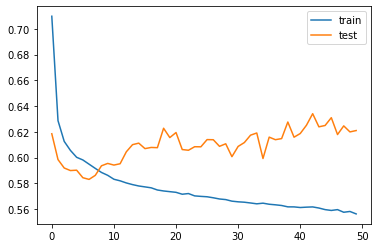

In [7]:
# design network
model = Sequential()
model.add(LSTM(30,return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(30))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
# fit network
history = model.fit(X_train, Y_train, epochs=50, batch_size=512, validation_data=(X_test, Y_test), shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [367]:
len(labels)

8672

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
actual= np.argmax(Y_test, axis=1)
predicted = np.argmax(model.predict(X_test, batch_size=512), axis=1)
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.68      0.42      0.52      4889
           1       0.71      0.95      0.82     21858
           2       0.77      0.05      0.09      5846

    accuracy                           0.71     32593
   macro avg       0.72      0.47      0.47     32593
weighted avg       0.72      0.71      0.64     32593



In [373]:
ticker = yf.Ticker('GBPJPY=X')

data_test = ticker.history(period='6h', interval='1m')
cols = ['Open','High', 'Low', 'Close']
data_test = data_test[cols]

In [374]:
from tqdm import tqdm
result = pd.DataFrame(index=data_test.index)

for i in tqdm(range(0,len(data_test)-1)):
    if i > 50:
        try:
            sbs = data_test.iloc[i:i+50]
            pred = model.predict(sbs.apply(MinMax, axis=0).values.reshape(1,50,4))
            result.loc[sbs.index[-1], 'Price'] = sbs['Close'][-1]
            result.loc[sbs.index[-1], 'Indicator'] = np.argmax(pred)
            result.loc[sbs.index[-1], 'Strength'] = np.max(pred)
        except:
            pass
        

results = data_test.join(result)

100%|██████████| 299/299 [00:06<00:00, 44.10it/s]


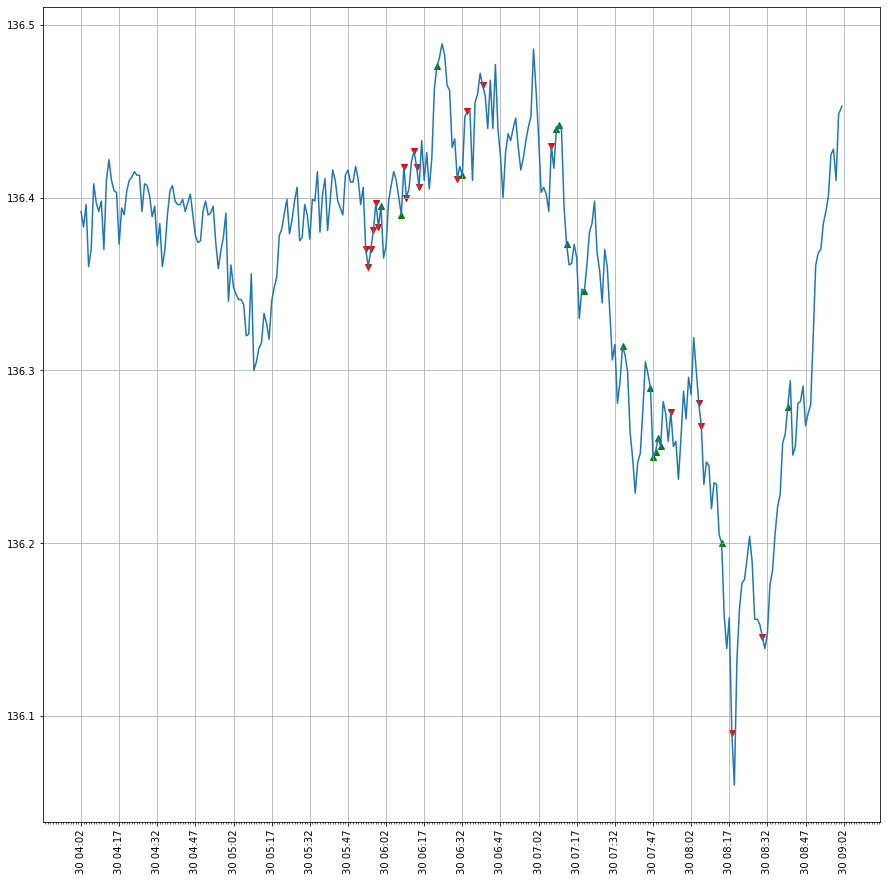

In [375]:
from matplotlib.dates import MinuteLocator, HourLocator, SecondLocator


fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.plot(results['Close'].index,results['Close'])
ax.scatter(results[(results['Indicator']==0) & (results['Strength']>0.0)].index,
            results[(results['Indicator']==0) & (results['Strength']>0.0)]['Price'],
            color='red', marker='v')
ax.scatter(results[(results['Indicator']==2) & (results['Strength']>0.0)].index,
            results[(results['Indicator']==2) & (results['Strength']>0.0)]['Price'],
            color='green', marker='^')
sloc = MinuteLocator()
mloc = MinuteLocator(interval=15)
ax.xaxis.set_major_locator(mloc)
ax.xaxis.set_minor_locator(sloc)

ax.grid(True)
plt.xticks(rotation=90)
plt.show()

In [376]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
fig.add_trace(go.Candlestick(x=results.index,
                open=results['Open'],
                high=results['High'],
                low=results['Low'],
                close=results['Close']))
fig.add_trace(go.Scatter(x=results[results['Indicator']==0].index,
                         y=results[results['Indicator']==0]['Price'],
                    mode='markers',
                    name='Down',
                    marker=dict(
                        size=results[results['Indicator']==0]['Strength']*10
                    ),
                        marker_symbol='triangle-down'))
fig.add_trace(go.Scatter(x=results[results['Indicator']==2].index,
                         y=results[results['Indicator']==2]['Price'],
                    mode='markers',
                    name='Up',
                    marker=dict(
                        size=results[results['Indicator']==2]['Strength']*10
                    ),
                        marker_symbol='triangle-up'))



fig.show()

In [38]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector, Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras.losses import MSE


def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std=1.):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    x = Input(shape=(timesteps, input_dim))

    # LSTM encoding
    h = LSTM(intermediate_dim)(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + z_log_sigma * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # decoded LSTM layer
    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    # decoded layer
    x_decoded_mean = decoder_mean(h_decoded)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        xent_loss = MSE(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss

    vae.compile(optimizer='rmsprop', loss=vae_loss)
    
    return vae

In [46]:
vae = create_lstm_vae(4, 
    128, 
    32, 
    10, 
    6,
    epsilon_std=1.)

In [47]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 4)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               42000     
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 42,606
Trainable params: 42,606
Non-trainable params: 0
_________________________________________________________________


In [2]:
X.dtype

dtype('float32')

In [3]:
import os

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Reshape,Input, LSTM, RepeatVector, Flatten, Dense, Dropout, Lambda, Multiply, Add, Concatenate, Conv1D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.losses import MSE
from model_utils import nll, KLDivergenceLayer, relu_tanh


In [4]:
ls_size = 6
sample_length = 128
n_features = 4


In [5]:
encoder_input = Input(shape=(sample_length, n_features,1), name='encoder_input')

eps = Input(tensor=K.random_normal(stddev=1.0, shape = (K.shape(encoder_input)[0], ls_size)), name='epsilon')
decoder_input = Input(shape=(ls_size,), name='decoder_input')

def build_encoder(encoder_input, eps):
    net = Conv2D(256, 3, padding='same', activation='relu', name='encoder_conv1')(encoder_input)

    net=Flatten()(net)

    z_mean = Dense(ls_size, name='encoder_zmean')(net)

    z_stddev = Dense(ls_size, name='encoder_zstd')(net)

    z_mu, z_logvar = KLDivergenceLayer()([z_mean,z_stddev], beta=0.5)

    z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma_vect')(z_logvar)

    z_eps = Multiply()([z_sigma, eps])

    z = Add(name='encoder_z')([z_mu, z_eps])
    return z_mu, z_sigma, z

def build_decoder(decoder_input):

    dec = Dense(sample_length*n_features*256, activation='relu')(decoder_input)

    dec = Reshape(target_shape=(128,4, 256))(dec)

    dec = Conv2D(256, 3, padding='same', activation='relu')(dec)

    dec_out = Conv2D(1, 1,activation=relu_tanh)(dec)
    
    return dec_out

In [6]:
z_mu, z_sigma, z = build_encoder(encoder_input=encoder_input, eps=eps)

training_dec_out = build_decoder(decoder_input=z)

model_train = Model(inputs=[encoder_input, eps], outputs=[training_dec_out])

decoder_out = build_decoder(decoder_input=decoder_input)

model_encoder = Model(inputs=[encoder_input, eps], outputs=[z_mu, z_sigma, z])

model_decoder = Model(inputs=[decoder_input], outputs = [decoder_out])








In [7]:
K.clip()

TypeError: clip() missing 3 required positional arguments: 'x', 'min_value', and 'max_value'

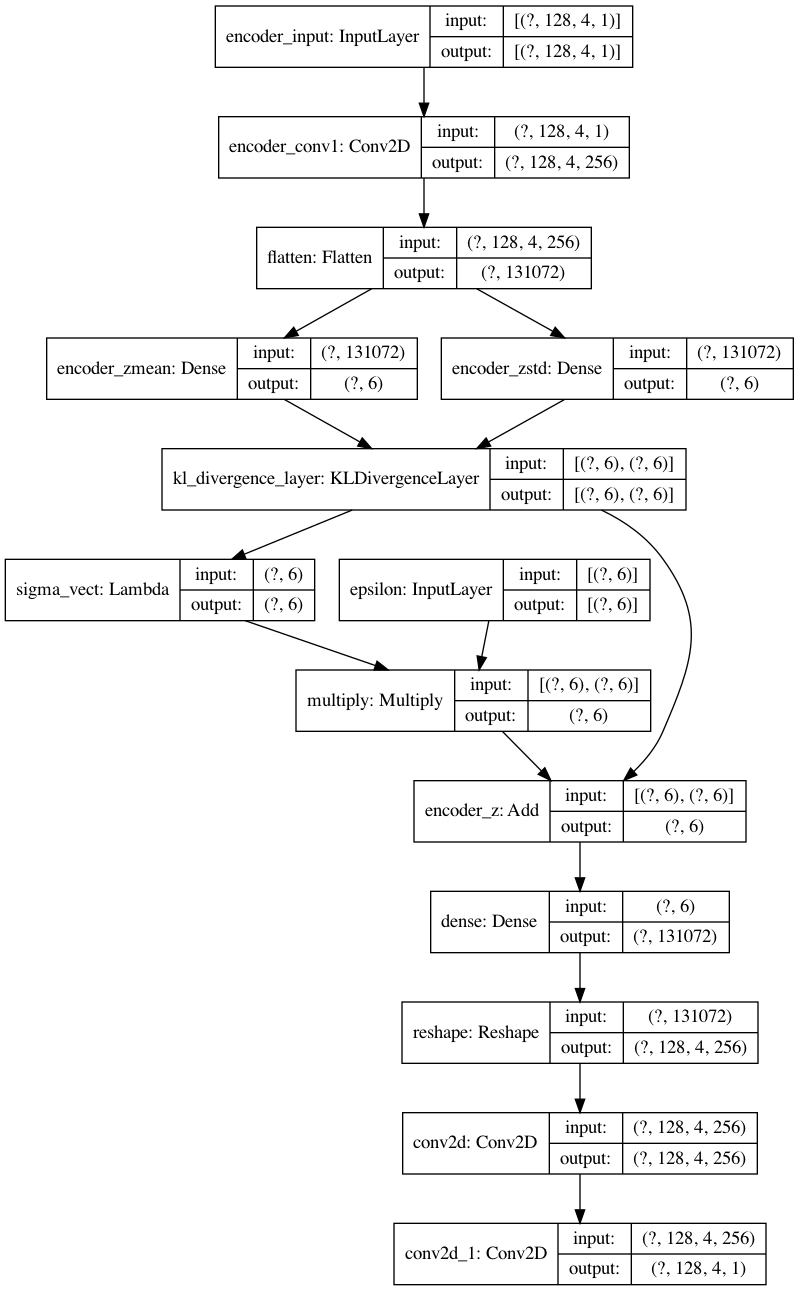

In [8]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model

plot_model(model_train, show_shapes=True)

In [9]:
SGD_clip = SGD(lr=0.01, clipnorm=1.0)


In [10]:
cust_adam = Adam(lr= 0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [11]:
model_train.compile(optimizer=SGD_clip, loss=nll)

In [12]:
model_train.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 4, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv1 (Conv2D)          (None, 128, 4, 256)  2560        encoder_input[0][0]              
__________________________________________________________________________________________________
flatten (Flatten)               (None, 131072)       0           encoder_conv1[0][0]              
__________________________________________________________________________________________________
encoder_zmean (Dense)           (None, 6)            786438      flatten[0][0]                    
______________________________________________________________________________________________

In [13]:
history = model_train.fit(x=X_train,y=X_train, epochs=10, shuffle=True, batch_size=32, validation_split=0.2)

Train on 104296 samples, validate on 26075 samples
Epoch 1/10
    32/104296 [..............................] - ETA: 2:05

ValueError: The two structures don't have the same nested structure.

First structure: type=list str=[<tf.Tensor 'IteratorGetNext:0' shape=(None, 128, 4, 1) dtype=float32>]

Second structure: type=list str=[tf.float32, tf.float32]

More specifically: The two structures don't have the same number of elements. First structure: type=list str=[<tf.Tensor 'IteratorGetNext:0' shape=(None, 128, 4, 1) dtype=float32>]. Second structure: type=list str=[tf.float32, tf.float32]
Entire first structure:
[.]
Entire second structure:
[., .]